## Residual diagnostics
***
A good forecasting method will yield innovation residuals with the following properties:

1. The innovation residuals are uncorrelated. If there are correlations between innovation residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The innovation residuals have zero mean. If they have a mean other than zero, then the forecasts are biased.

Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

If either of these properties is not satisfied, then the forecasting method can be modified to give better forecasts. Adjusting for bias is easy: if the residuals have mean $m$, then simply subtract $m$ from all forecasts and the bias problem is solved. Fixing the correlation problem is harder, and we will not address it until Chapter 10.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

3. The innovation residuals have constant variance. This is known as “homoscedasticity”.
4. The innovation residuals are normally distributed.

These two properties make the calculation of prediction intervals easier (see Section 5 for an example). However, a forecasting method that does not satisfy these properties cannot necessarily be improved. Sometimes applying a Box-Cox transformation may assist with these properties, but otherwise there is usually little that you can do to ensure that your innovation residuals have constant variance and a normal distribution. Instead, an alternative approach to obtaining prediction intervals is necessary. We will show how to deal with non-normal innovation residuals in Section 5.5.

## Example: Forecasting Google daily closing stock prices

We will continue with the Google daily closing stock price example from Section 5.2. For stock market prices and indexes, the best forecasting method is often the naïve method. That is, each forecast is simply equal to the last observed value, or $\hat{y}_{t}=y_{t-1}$ . Hence, the residuals are simply equal to the difference between consecutive observations:

\begin{gather*} 
e_{t}=y_{t}-\hat{y}_{t}=y_{t}-y_{t-1}
\end{gather*}

The following graph shows the Google daily closing stock price for trading days during 2015. The large jump corresponds to 17 July 2015 when the price jumped 16% due to unexpectedly strong second quarter results. (The `google_2015` object was created in Section 2)



In [2]:
#Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
import statsmodels

from statsforecast import StatsForecast
from statsforecast.models import __all__

import matplotlib.pyplot as plt

In [3]:
# Create a dataframe from a csv file:
google_stock = pd.read_csv("Assets/GOOGL.csv")

# Filter the year of interest:
google_mask = google_stock["Date"] <= "2015-12-31"
google_2015 = google_stock[google_mask]

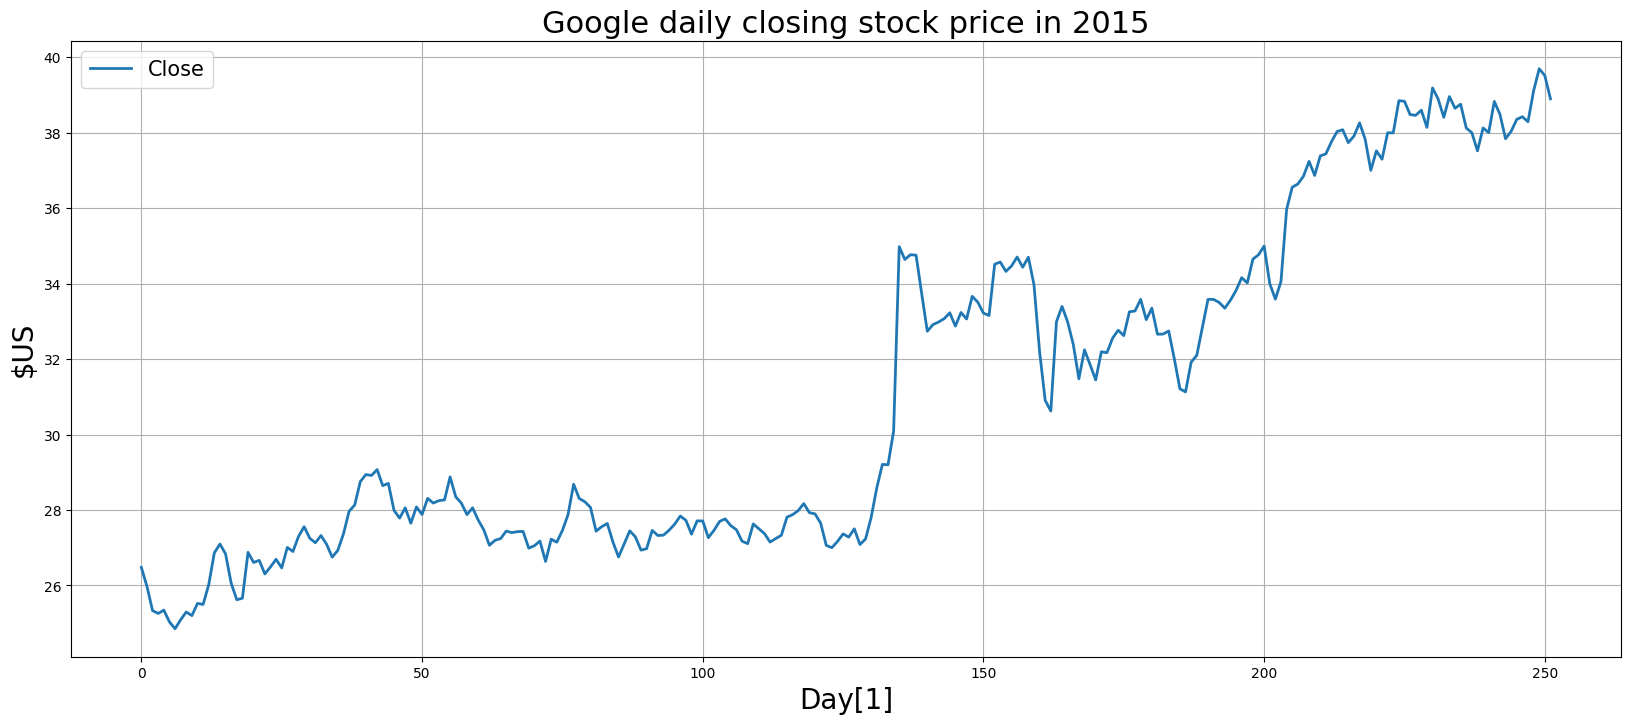

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
google_2015['Close'].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Google daily closing stock price in 2015', fontsize=22)
ax.set_ylabel('$US', fontsize=20)
ax.set_xlabel('Day[1]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p align="center">
Figure 9: Daily Google stock prices in 2015.
</p>

The residuals obtained from forecasting this series using the naïve method are shown in Figure 10. The large positive residual is a result of the unexpected price jump in July.

In [5]:
# Naive method:
from statsforecast.models import Naive

# Create arrays with Close values: 
y_google_2015 = google_2015["Close"].values

# Define the model, fit and predict:
model = Naive()
model = model.fit(y=y_google_2015)
naive = model.predict(h=10)

In [6]:
def augment(model_name, time_var, obs_values):

    type_model_list = []
    for n in range(len(obs_values)):
        type_model_list.append(model_name)
        n += 1
    fitted_values = model.predict_in_sample()
    residuals = obs_values - fitted_values["mean"]

    augment_df = pd.DataFrame({'model':type_model_list,
                        'time_var':time_var,
                        'obs_values':obs_values,
                        'fitted_values':fitted_values["mean"],
                        'residuals':residuals})

    return(augment_df)

In [7]:
aug_df = augment("Naive", google_2015["Date"], google_2015["Close"])

In [8]:
aug_df

,model,time_var,obs_values,fitted_values,residuals
0,Naive,2015-01-02,26.477501,NaN,NaN
1,Naive,2015-01-05,25.973000,26.477501,-0.504501
2,Naive,2015-01-06,25.332001,25.973000,-0.640999
3,Naive,2015-01-07,25.257500,25.332001,-0.074501
4,Naive,2015-01-08,25.345501,25.257500,0.088001
...,...,...,...,...,...
247,Naive,2015-12-24,38.292000,38.425499,-0.133499
248,Naive,2015-12-28,39.112000,38.292000,0.820000
249,Naive,2015-12-29,39.698002,39.112000,0.586002
250,Naive,2015-12-30,39.514999,39.698002,-0.183003


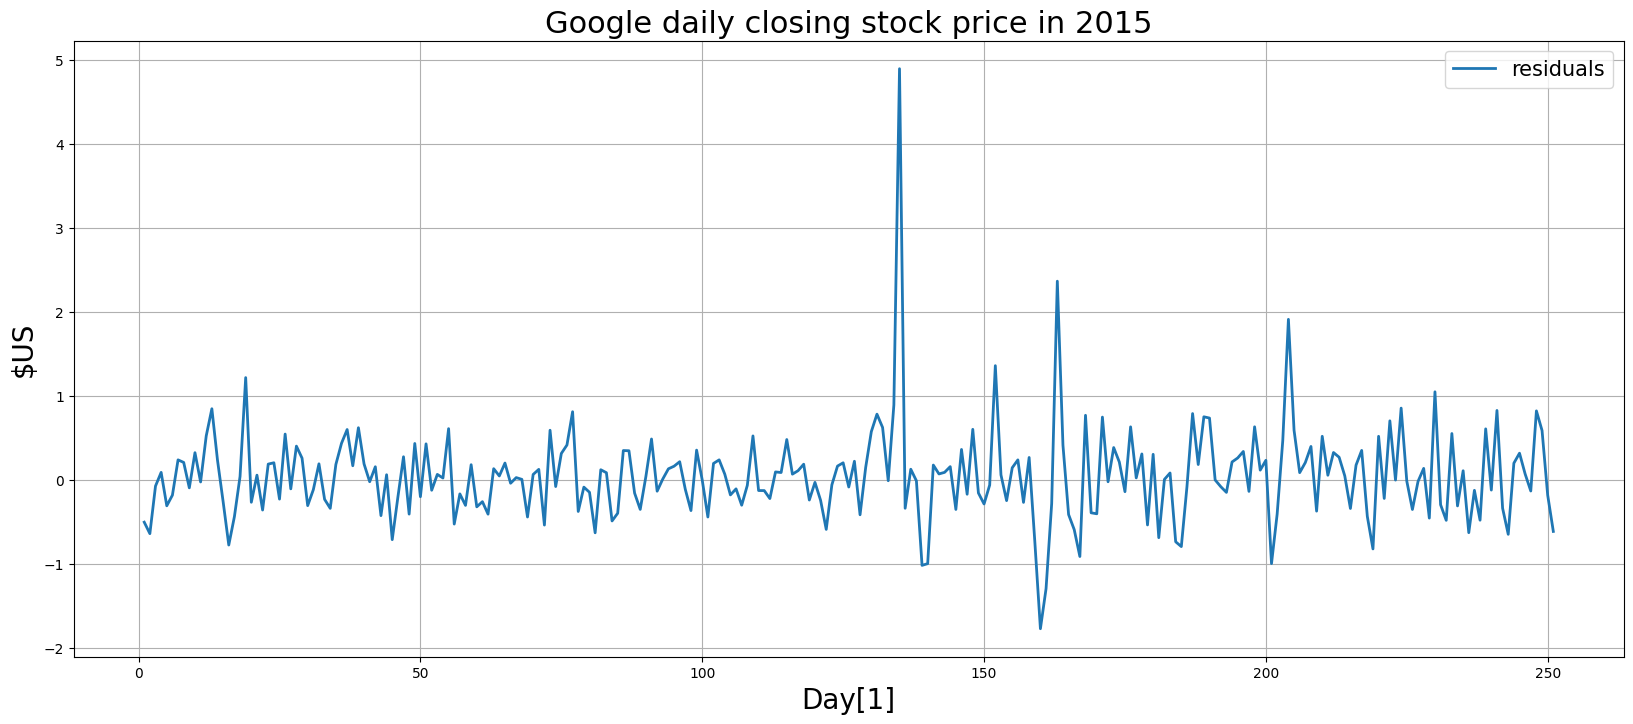

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
aug_df['residuals'].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Google daily closing stock price in 2015', fontsize=22)
ax.set_ylabel('$US', fontsize=20)
ax.set_xlabel('Day[1]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

<p align="center">
Figure 10: Residuals from forecasting the Google stock price using the naïve method.
</p>

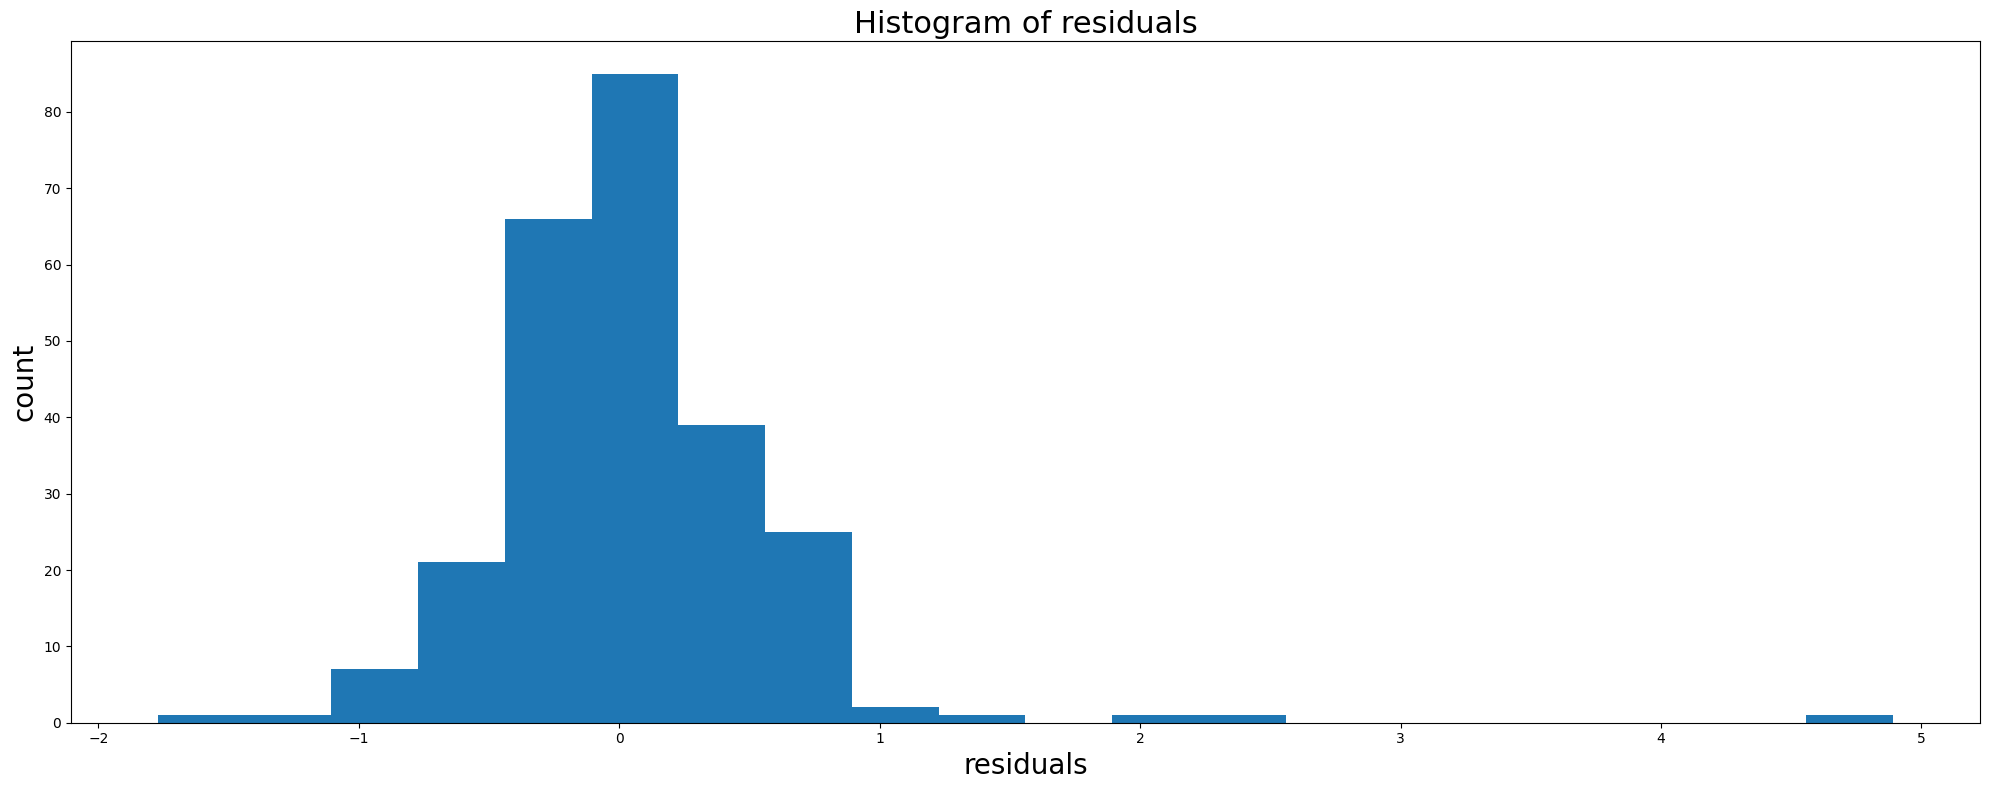

In [10]:
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(20, 8),
                        tight_layout = True)
 
axs.hist(aug_df["residuals"], bins = 20)

# Specify graph features:
axs.set_title('Histogram of residuals', fontsize=22)
axs.set_ylabel('count', fontsize=20)
axs.set_xlabel('residuals', fontsize=20)
 
# Show plot
plt.show()

<p align="center">
Figure 11: Histogram of the residuals from the naïve method applied to the Google stock price. The right tail seems a little too long for a normal distribution.
</p>


Text(0, 0.5, 'ACF')

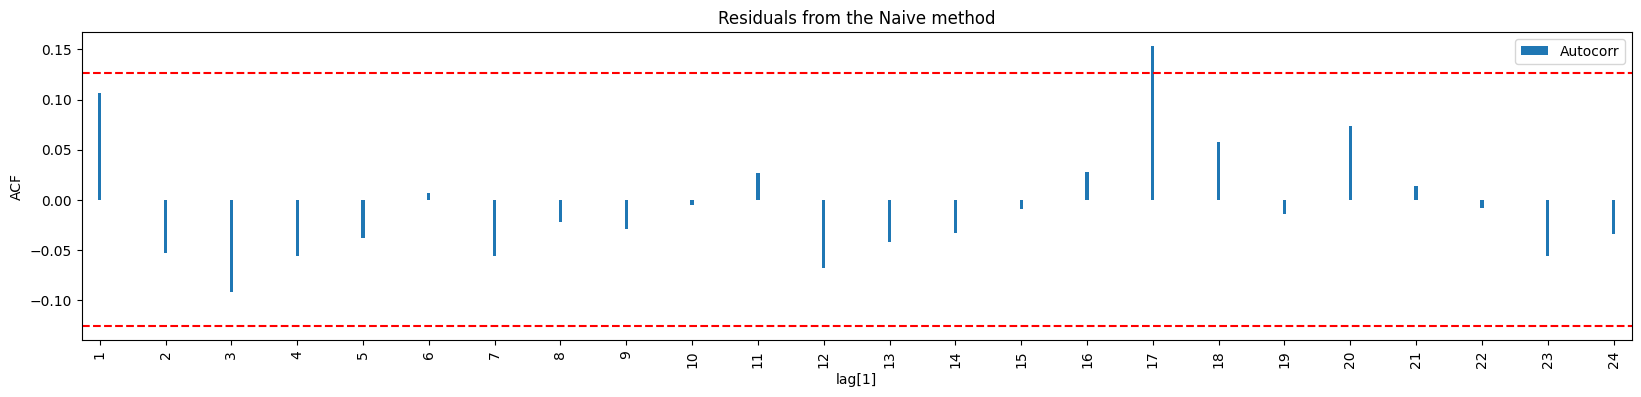

In [11]:
import math

ticker_data = aug_df["residuals"]
ticker_data_acf = [ticker_data.autocorr(i) for i in range(1,25)]

test_df = pd.DataFrame([ticker_data_acf]).T
test_df.columns = ['Autocorr']
test_df.index += 1
test_df.plot(kind='bar', width = 0.05, figsize = (20, 4))

# Statisfical significance.
n = len(aug_df['residuals'])
plt.axhline(y = 2/math.sqrt(n), color = 'r', linestyle = 'dashed')
plt.axhline(y = -2/math.sqrt(n), color = 'r', linestyle = 'dashed')

# Adding plot title.
plt.title("Residuals from the Naive method")
 
# Providing x-axis name.
plt.xlabel("lag[1]")

# Providing y-axis name.
plt.ylabel("ACF")

These graphs show that the naïve method produces forecasts that appear to account for all available information. The mean of the residuals is close to zero and there is no significant correlation in the residuals series. The time plot of the residuals shows that the variation of the residuals stays much the same across the historical data, apart from the one outlier, and therefore the residual variance can be treated as constant. This can also be seen on the histogram of the residuals. The histogram suggests that the residuals may not be normal — the right tail seems a little too long, even when we ignore the outlier. Consequently, forecasts from this method will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.

## Portmanteau tests for autocorrelation

In addition to looking at the ACF plot, we can also do a more formal test for autocorrelation by considering a whole set of $r_{k}$ values as a group, rather than treating each one separately.

Recall that $r_{k}$ is the autocorrelation for lag $k$. When we look at the ACF plot to see whether each spike is within the required limits, we are implicitly carrying out multiple hypothesis tests, each one with a small probability of giving a false positive. When enough of these tests are done, it is likely that at least one will give a false positive, and so we may conclude that the residuals have some remaining autocorrelation, when in fact they do not.

In order to overcome this problem, we test whether the first $ℓ$ autocorrelations are significantly different from what would be expected from a white noise process. A test for a group of autocorrelations is called a **portmanteau test**, from a French word describing a suitcase or coat rack carrying several items of clothing.

One such test is the **Box-Pierce test**, based on the following statistic

\begin{gather*} 
Q = T \sum_{k = 1}^{ℓ} r^{2}_{k}
\end{gather*}

where $ℓ$ is the maximum lag being considered and $T$ is the number of observations. If each $r_{k}$ is close to zero, then $Q$ will be small. If some  $r_{k}$ values are large (positive or negative), then $Q$ will be large. We suggest using $ℓ=10$ for non-seasonal data and $ℓ=2m$ for seasonal data, where $m$  is the period of seasonality. However, the test is not good when $ℓ$ is large, so if these values are larger than $T/5$, then use $ℓ=T/5$

A related (and more accurate) test is the **Ljung-Box test**, based on

\begin{gather*} 
Q* = T (T + 2) \sum_{k = 1}^{ℓ} (T - k)^{-1} r^{2}_{k}
\end{gather*}

Again, large values of $Q∗$ suggest that the autocorrelations do not come from a white noise series.

How large is too large? If the autocorrelations did come from a white noise series, then both $Q$ and $Q∗$ would have a $χ2$ distribution with $(ℓ−K)$ degrees of freedom, where $K$ is the number of parameters in the model. If they are calculated from raw data (rather than the residuals from a model), then set $K=0$.

For the Google stock price example, the naïve method has no parameters, so $K=0$ in that case also. In the following code, $lag=ℓ$ and $dof=K$.

In [12]:
df_box_pierce = statsmodels.stats.diagnostic.acorr_ljungbox(test_df, lags=10, boxpierce=True, model_df=1)
df_box_pierce = df_box_pierce[["bp_stat","bp_pvalue"]]
df_box_pierce.tail(1)

,bp_stat,bp_pvalue
10,3.972058,0.913242


In [13]:
ljung_box = statsmodels.stats.diagnostic.acorr_ljungbox(test_df, lags=10, model_df=1)
ljung_box.tail(1)

,lb_stat,lb_pvalue
10,5.238618,0.813031


For both $Q$ and $Q∗$, the results are not significant (i.e., the $p$-values are relatively large). Thus, we can conclude that the residuals are not distinguishable from a white noise series.

An alternative simple approach that may be appropriate for forecasting the Google daily closing stock price is the drift method. The tidy() function shows the one estimated parameter, the drift coefficient, measuring the average daily change observed in the historical data.

In [14]:
# RandomWalkWithDrift's usage example:
from statsforecast.models import RandomWalkWithDrift

# Define the model, fit and predict:
model = RandomWalkWithDrift()
model = model.fit(y=y_google_2015)
y_hat_dict = model.predict(h=10)

Applying the Ljung-Box test, we set $K=1$ to account for the estimated parameter.

In [15]:
aug_df_drift = augment("Drift", google_2015["Date"], google_2015["Close"])

ticker_data = aug_df_drift["residuals"]
ticker_data_acf = [ticker_data.autocorr(i) for i in range(1,25)]
test_df = pd.DataFrame([ticker_data_acf]).T
test_df.columns = ['Autocorr']
test_df.index += 1

ljung_box = statsmodels.stats.diagnostic.acorr_ljungbox(test_df, lags=10, model_df=1)
ljung_box.tail(1)

,lb_stat,lb_pvalue
10,5.238661,0.813027


As with the naïve method, the residuals from the drift method are indistinguishable from a white noise series.